# Bayesian regression and imputation of missing values in MS-based proteomics

In [1]:
import torch
import torch.distributions.constraints as constraints
import pyro
import pyro.distributions as dist
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, MCMC, NUTS, config_enumerate, infer_discrete
from pyro.infer.autoguide import AutoDiagonalNormal, AutoDelta, AutoNormal
import pyro.poutine as poutine

from scipy.stats import norm

import pandas as pd
import numpy as np
import copy

import matplotlib.pyplot as plt
%matplotlib inline

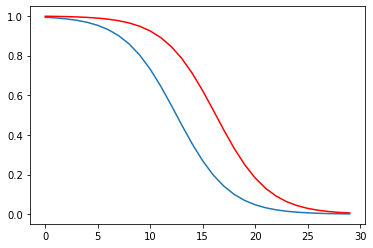

In [27]:
fig, ax = plt.subplots()

ax.plot(np.arange(0,30), np.array([1 / (1 + np.exp(-5 + (.4 * x))) for x in np.arange(0,30)])) 
ax.plot(np.arange(0,30), np.array([1 / (1 + np.exp(-6.5 + (.4 * x))) for x in np.arange(0,30)]), color='red') 

## Simulate dataset

In [2]:
## Simulate some data
def simulate_data(num_proteins, num_runs, num_features, mar_thresh=.05, censor_thresh=16., gen_missing=True):

    sim_data=pd.DataFrame()
    missing = list()
    mu = list()
    sigma = list()

    ## Generate data
    row=0
    for i in range(num_proteins):
        mu = dist.Uniform(15., 30.).sample()
        mu2 = mu-1
        mu3 = mu+1
        sigma = dist.Uniform(.5, 1.5).sample()
        
        for j in range(num_features):
            val = dist.Normal(mu, sigma).sample()
            sim_data.loc[row,"Intensity"] = float(val)
            sim_data.loc[row,"True_Intensity"] = float(val)
            sim_data.loc[row,"Run"] = 0
            sim_data.loc[row,"Protein"] = i
            sim_data.loc[row,"Feature"] = j
            sim_data.loc[row,"True_mean"] = float(mu)
            sim_data.loc[row,"True_std"] = float(sigma)
            
            val2 = dist.Normal(val-1., .05).sample()
            sim_data.loc[row+1,"Intensity"] = float(val2)
            sim_data.loc[row+1,"True_Intensity"] = float(val2)
            sim_data.loc[row+1,"Run"] = 1
            sim_data.loc[row+1,"Protein"] = i
            sim_data.loc[row+1,"Feature"] = j
            sim_data.loc[row+1,"True_mean"] = float(mu2)
            sim_data.loc[row+1,"True_std"] = float(sigma)
            
            val3 = dist.Normal(val+1., .05).sample()
            sim_data.loc[row+2,"Intensity"] = float(val3)
            sim_data.loc[row+2,"True_Intensity"] = float(val3)
            sim_data.loc[row+2,"Run"] = 2
            sim_data.loc[row+2,"Protein"] = i
            sim_data.loc[row+2,"Feature"] = j
            sim_data.loc[row+2,"True_mean"] = float(mu3)
            sim_data.loc[row+2,"True_std"] = float(sigma)
            
            row+=3
    
    if gen_missing:
        for i in range(len(sim_data)):
            mar = np.random.uniform(0,1)
            if mar < mar_thresh:
                sim_data.loc[i, "Intensity"] = np.nan
                sim_data.loc[i, "MAR"] = True
            else:
                sim_data.loc[i, "MAR"] = False

            if sim_data.loc[i, "True_Intensity"] < censor_thresh:
                sim_data.loc[i, "Intensity"] = np.nan
                sim_data.loc[i, "MNAR"] = True
            else:
                sim_data.loc[i, "MNAR"] = False


    sim_data.loc[:, "Missing"] = np.isnan(sim_data["Intensity"])*1
    
    return sim_data

In [3]:
sim_data = simulate_data(50, 3,10, mar_thresh=.1, censor_thresh=16., gen_missing=False)
sim_data

,Intensity,True_Intensity,Run,Protein,Feature,True_mean,True_std,Missing
0,27.808708,27.808708,0.0,0.0,0.0,28.039415,1.142629,0
1,26.880814,26.880814,1.0,0.0,0.0,27.039415,1.142629,0
2,28.816219,28.816219,2.0,0.0,0.0,29.039415,1.142629,0
3,28.541010,28.541010,0.0,0.0,1.0,28.039415,1.142629,0
4,27.552336,27.552336,1.0,0.0,1.0,27.039415,1.142629,0
...,...,...,...,...,...,...,...,...
1495,22.808657,22.808657,1.0,49.0,8.0,22.480053,0.506102,0
1496,24.665592,24.665592,2.0,49.0,8.0,24.480053,0.506102,0
1497,23.489378,23.489378,0.0,49.0,9.0,23.480053,0.506102,0
1498,22.574316,22.574316,1.0,49.0,9.0,22.480053,0.506102,0


In [4]:
missing_data = simulate_data(50, 3, 10, mar_thresh=.1, censor_thresh=16., gen_missing=True)
missing_data

,Intensity,True_Intensity,Run,Protein,Feature,True_mean,True_std,MAR,MNAR,Missing
0,28.335625,28.335625,0.0,0.0,0.0,28.555939,1.061807,False,False,0
1,27.307644,27.307644,1.0,0.0,0.0,27.555939,1.061807,False,False,0
2,29.436708,29.436708,2.0,0.0,0.0,29.555939,1.061807,False,False,0
3,NaN,29.277670,0.0,0.0,1.0,28.555939,1.061807,True,False,1
4,28.257521,28.257521,1.0,0.0,1.0,27.555939,1.061807,False,False,0
...,...,...,...,...,...,...,...,...,...,...
1495,19.921778,19.921778,1.0,49.0,8.0,19.915047,0.884063,False,False,0
1496,NaN,21.907801,2.0,49.0,8.0,21.915047,0.884063,True,False,1
1497,20.675140,20.675140,0.0,49.0,9.0,20.915047,0.884063,False,False,0
1498,NaN,19.698828,1.0,49.0,9.0,19.915047,0.884063,True,False,1


## Tukey Median Polish
median polish from R converted into Python

In [88]:
def median_polish(x, eps = 0.01, maxiter=10, trace_iter=True, na_rm=False):

    z=copy.copy(x)
    nr = x.shape[0]
    nc = x.shape[1]
    t = 0
    oldsum = 0
    
    r = np.array([0 for i in range(nr)])
    c = np.array([0 for i in range(nc)])
    
    for iter in range(maxiter):
        rdelta=list()
        if na_rm:
            for i in range(nr):
                rdelta.append(np.nanmedian(z[i,:]))
        else:
            for i in range(nr):
                rdelta.append(np.median(z[i,:]))
        rdelta = np.array(rdelta)
        
        z = z - np.repeat(rdelta, nc, axis=0).reshape(nr,nc)
        r = r + rdelta
        if na_rm:
            delta = np.nanmedian(c)
        else:
            delta = np.median(c)
        c = c - delta
        t = t + delta
        
        cdelta=list()
        if na_rm:
            for i in range(nc):
                cdelta.append(np.nanmedian(z[:,i]))
        else:
            for i in range(nc):
                cdelta.append(np.median(z[:,i]))
        cdelta = np.array(cdelta)
        
        z = z - np.repeat(cdelta, nr, axis=0).reshape(nr,nc, order='F')
        c = c + cdelta
        
        if na_rm:
            delta = np.nanmedian(r)
        else:
            delta = np.median(r)

        r = r - delta
        t = t + delta
        
        if na_rm:
            newsum = np.nansum(abs(z))
        else:
            newsum = np.sum(abs(z))
            
        converged = (newsum == 0) | (abs(newsum - oldsum) < eps * newsum)
        if converged:
            break
        oldsum = newsum
        if trace_iter: 
            print("{0}: {1}\n".format(str(iter), str(newsum)))
    
    ## TODO Add in converged info
    # if (converged) {
    # if (trace.iter) 
    #   cat("Final: ", newsum, "\n", sep = "")
    # }
    # else warning(sprintf(ngettext(maxiter, "medpolish() did not converge in %d iteration", 
    # "medpolish() did not converge in %d iterations"), maxiter), 
    # domain = NA)
    
    ans = {"overall" : t, "row" : r, "col" : c, "residuals" : z}
    return(ans)

In [176]:
median_polish(sim_data[sim_data["Protein"] == 0]["Intensity"].values.reshape(10,3),na_rm=True)

0: 2.373464584350586

1: 0.376220703125



{'overall': 29.20374870300293,
 'row': array([-2.56967735e+00, -2.12400436e+00,  2.83622742e-03,  9.80799675e-01,
         2.22353935e+00, -2.83622742e-03,  3.01180458e+00, -2.63908386e-01,
        -1.18820572e+00,  6.09798431e-02]),
 'col': array([ 0.        , -0.97211647,  1.01974487]),
 'residuals': array([[-0.00343513,  0.0812149 ,  0.        ],
        [ 0.00343513, -0.01698303,  0.        ],
        [ 0.00942421,  0.        , -0.02878952],
        [-0.01656055,  0.01656055,         nan],
        [-0.01114464,  0.02197647,  0.        ],
        [-0.00942421,  0.        ,  0.03227234],
        [ 0.        , -0.02781487,  0.03012085],
        [ 0.02532387, -0.01564789,  0.        ],
        [ 0.02394485,  0.        , -0.00214767],
        [        nan,  0.        ,         nan]])}

In [177]:
sim_data[sim_data["Protein"] == 0]["Intensity"].values.reshape(10,3)

array([[26.63063622, 25.74316978, 27.65381622],
       [27.08317947, 26.09064484, 28.09948921],
       [29.21600914, 28.23446846, 30.19754028],
       [30.16798782, 29.22899246,         nan],
       [31.41614342, 30.47714806, 32.44703293],
       [29.19148827, 28.22879601, 30.25292969],
       [32.21555328, 31.21562195, 33.26541901],
       [28.96516418, 27.95207596, 29.95958519],
       [28.03948784, 27.04342651, 29.03314018],
       [        nan, 28.29261208,         nan]])

## Bayesian Regression

In [187]:
data = sim_data.loc[:, ["Run", "Feature", "Intensity"]]
data.loc[:, "Run"] = data.loc[:, "Run"].astype(str)
data.loc[:, "Feature"] = data.loc[:, "Feature"].astype(str)
data = pd.get_dummies(data, drop_first=True)
data = data.values.reshape(10, 30, 12)

In [15]:
svi = SVI(regression_model,
          regression_guide,
          Adam({"lr": .05}),
          loss=Trace_ELBO())

pyro.clear_param_store()
num_iters = 2000
for i in range(num_iters):
    elbo = svi.step(torch.tensor(data))
    if i % 100 == 0:
        print(elbo)

6099.742444681874
812.7583306426781
706.7580097004401
630.0779116253176
593.6767003067433
522.503868565602
432.8150115872316
418.84418236581354
340.78001925668576
316.64639121680807
325.0947824444604
275.9396125562637
285.72189305890697
243.76107213531782
236.79994747632122
224.03579620121184
191.9959417922264
210.60308861067796
180.75136391928956
203.09401736213857


In [16]:
pyro.get_param_store().get_all_param_names()

dict_keys(['mu_loc_0', 'mu_scale_0', 'sigma_loc_0', 'sigma_scale_0', 'br_loc_0', 'br_scale_0', 'bf_loc_0', 'bf_scale_0', 'mu_loc_1', 'mu_scale_1', 'sigma_loc_1', 'sigma_scale_1', 'br_loc_1', 'br_scale_1', 'bf_loc_1', 'bf_scale_1', 'mu_loc_2', 'mu_scale_2', 'sigma_loc_2', 'sigma_scale_2', 'br_loc_2', 'br_scale_2', 'bf_loc_2', 'bf_scale_2', 'mu_loc_3', 'mu_scale_3', 'sigma_loc_3', 'sigma_scale_3', 'br_loc_3', 'br_scale_3', 'bf_loc_3', 'bf_scale_3', 'mu_loc_4', 'mu_scale_4', 'sigma_loc_4', 'sigma_scale_4', 'br_loc_4', 'br_scale_4', 'bf_loc_4', 'bf_scale_4', 'mu_loc_5', 'mu_scale_5', 'sigma_loc_5', 'sigma_scale_5', 'br_loc_5', 'br_scale_5', 'bf_loc_5', 'bf_scale_5', 'mu_loc_6', 'mu_scale_6', 'sigma_loc_6', 'sigma_scale_6', 'br_loc_6', 'br_scale_6', 'bf_loc_6', 'bf_scale_6', 'mu_loc_7', 'mu_scale_7', 'sigma_loc_7', 'sigma_scale_7', 'br_loc_7', 'br_scale_7', 'bf_loc_7', 'bf_scale_7', 'mu_loc_8', 'mu_scale_8', 'sigma_loc_8', 'sigma_scale_8', 'br_loc_8', 'br_scale_8', 'bf_loc_8', 'bf_scale_8',

In [17]:
from sklearn.linear_model import LinearRegression

<AxesSubplot:>

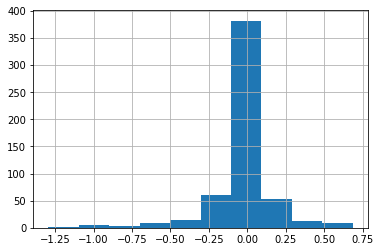

In [1130]:
error = list()
for i in range(data.shape[0]):
    reg = LinearRegression()
    reg.fit(data[i, :, 1:], data[i, :, 0])
    
    bayes_coef = np.concatenate((pyro.param('br_loc_{0}'.format(i)).data.numpy(), 
                    pyro.param('bf_loc_{0}'.format(i)).data.numpy()))
    temp_error= bayes_coef - reg.coef_
    error.append(temp_error)
    
    for j in temp_error:
        if j < -2:
            print(i, j)
pd.Series(np.array(error).flatten()).hist()

In [48]:
def regression_model(data=None, num_proteins=50, num_features = 9, num_runs = 2):
    
    for protein in pyro.plate("protein", num_proteins):
    
        mu = pyro.sample("mu_{0}".format(protein), dist.Uniform(10.,35.))
        sigma = pyro.sample("sigma_{0}".format(protein), 
                    dist.Uniform(0.,20.))
        
        with pyro.plate("runs_{}".format(protein), num_runs):
            br = pyro.sample("bR_{0}".format(protein), 
                             dist.Normal(torch.zeros(num_runs), torch.ones(num_runs)))
        with pyro.plate("features_{}".format(protein), num_features):    
            bf = pyro.sample("bF_{0}".format(protein), 
                         dist.Normal(torch.zeros(num_features), torch.ones(num_features)))
        
        mean = mu + torch.sum(br*data[protein, :,1:3], dim=1) + torch.sum(bf*data[protein, :,3:], dim=1)
        
        with pyro.plate("data_{0}".format(protein), len(data[protein, :, 0])):
            pyro.sample("obs_{0}".format(protein), 
                        dist.Normal(mean, sigma), obs=data[protein, :, 0])

def regression_guide(data=None, num_proteins=50, num_features = 9, num_runs = 2):
    
    for protein in pyro.plate("protein", num_proteins):
        
        ## Sample mean
        mu_loc = pyro.param("mu_loc_{}".format(protein), torch.tensor(20.))
        mu_scale = pyro.param("mu_scale_{}".format(protein), torch.tensor(2.),
                             constraint=constraints.positive)
        mu = pyro.sample("mu_{}".format(protein), dist.Normal(mu_loc, mu_scale))
        
        ## Sample std
        sigma_loc = pyro.param("sigma_loc_{}".format(protein), torch.tensor(0.))#,
                                 # constraint=constraints.positive)
        sigma_scale = pyro.param("sigma_scale_{}".format(protein), torch.tensor(.25),
                                 constraint=constraints.positive)
        sigma = pyro.sample("sigma_{}".format(protein),
                            dist.LogNormal(sigma_loc, sigma_scale))
        
        ## Coefficients
        br_loc = pyro.param("br_loc_{0}".format(protein), torch.randn(num_runs))
        br_scale = pyro.param("br_scale_{0}".format(protein), torch.ones(num_runs),
                                   constraint=constraints.positive)
        
        bf_loc = pyro.param("bf_loc_{0}".format(protein), torch.randn(num_features))
        bf_scale = pyro.param("bf_scale_{0}".format(protein), torch.ones(num_features),
                                   constraint=constraints.positive)

        with pyro.plate("runs_{}".format(protein), num_runs):
            br = pyro.sample("bR_{0}".format(protein), 
                             dist.Normal(br_loc, br_scale))
        with pyro.plate("features_{}".format(protein), num_features):    
            bf = pyro.sample("bF_{0}".format(protein), 
                             dist.Normal(bf_loc, bf_scale))
        
        ## Mean calculation
        mean = mu + torch.sum(br*data[protein, :,1:3], dim=1) + torch.sum(bf*data[protein, :,3:], dim=1)


In [49]:
data = sim_data.loc[:, ["Run", "Feature", "Intensity"]]
data.loc[:, "Run"] = data.loc[:, "Run"].astype(str)
data.loc[:, "Feature"] = data.loc[:, "Feature"].astype(str)
data = pd.get_dummies(data, drop_first=True)
data = data.values.reshape(50, 30, 12)

data = torch.tensor(data)

In [50]:
svi = SVI(regression_model,
          regression_guide,
          Adam({"lr": .05}),
          loss=Trace_ELBO())

pyro.clear_param_store()
num_iters = 2000
for i in range(num_iters):
    elbo = svi.step(data)
    if i % 100 == 0:
        print(elbo)

32139.50947711304
3926.2487358404132
3333.858943570297
3053.45155756803
2649.020654770304
2347.426076905025
2118.7309074748964
1883.2767649871928
1675.0504107416675
1607.7126453932801
1511.4194063774792
1309.610869548723
1196.110949747805
1057.5706869280862
1019.1559029444902
979.5197727514925
969.8623002879126
913.3595408750007
920.8747375294556
965.692517016714


<AxesSubplot:>

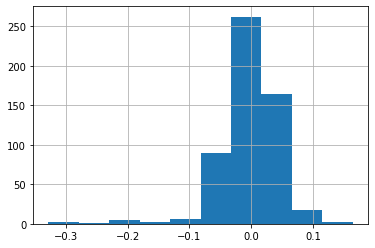

In [52]:
from sklearn.linear_model import LinearRegression

error = list()
for i in range(data.shape[0]):
    reg = LinearRegression()
    reg.fit(data[i, :, 1:], data[i, :, 0])
    
    bayes_coef = np.concatenate((pyro.param('br_loc_{0}'.format(i)).data.numpy(), 
                    pyro.param('bf_loc_{0}'.format(i)).data.numpy()))
    temp_error= bayes_coef - reg.coef_
    error.append(temp_error)
    
    for j in temp_error:
        if abs(j) > 1:
            print(i, j)

pd.Series(np.array(error).flatten()).hist()

## Bayesian Regression with missing value imputation, hard censor

### Model

In [9]:
def regression_model(data=None, num_proteins=50, num_features = 9, num_runs = 2, c=16.):
    
    ## MAR indicator
    alpha=torch.tensor(1.0)
    beta=torch.tensor(10.0)
    # mar_prob = pyro.sample("MAR", dist.Beta(alpha, beta))
    mar = pyro.sample("MAR", dist.Beta(alpha, beta))
    
    for protein in pyro.plate("protein", num_proteins):
    
        mu = pyro.sample("mu_{0}".format(protein), dist.Uniform(10.,35.))
        sigma = pyro.sample("sigma_{0}".format(protein), 
                    dist.Uniform(0.,10.))
        
        with pyro.plate("runs_{}".format(protein), num_runs):
            br = pyro.sample("bR_{0}".format(protein), 
                             dist.Normal(torch.zeros(num_runs), torch.ones(num_runs)))
        with pyro.plate("features_{}".format(protein), num_features):    
            bf = pyro.sample("bF_{0}".format(protein), 
                         dist.Normal(torch.zeros(num_features), torch.ones(num_features)))
        
        mean = mu + torch.sum(br*data[protein, :,2:4], dim=1) + torch.sum(bf*data[protein, :,4:], dim=1)
        
        cdf_prob = (c - mean)/sigma
        mnar = torch.tensor(norm.cdf(cdf_prob.detach().numpy()))
        
        with pyro.plate("data_{0}".format(protein), len(data[protein, :, 0])):

            # missing_prob = 1-((1-mnar) * (1-mar))
            missing_prob = mar * ((1-mar)*mnar)
            # print(mnar, mar)
            missing = pyro.sample("missing_{0}".format(protein), 
                        dist.Bernoulli(probs=missing_prob), 
                                  obs=data[protein, :, 1])
            
            with poutine.mask(mask=(missing == 0)):
                pyro.sample("obs_{0}".format(protein), 
                                dist.Normal(mean, sigma), obs=data[protein, :, 0])
            

def regression_guide(data=None, num_proteins=50, num_features = 9, num_runs = 2, c=16.):
    
    ## MAR
    alpha_q = pyro.param("alpha_q", torch.tensor(5.0),
                         constraint=constraints.positive)
    beta_q = pyro.param("beta_q", torch.tensor(30.0),
                        constraint=constraints.positive)
    mar_prob = pyro.sample("MAR", dist.Beta(alpha_q, beta_q))
    
    for protein in pyro.plate("protein", num_proteins):
        
        ## Sample mean
        mu_loc = pyro.param("mu_loc_{}".format(protein), torch.tensor(20.))
        mu_scale = pyro.param("mu_scale_{}".format(protein), torch.tensor(2.),
                             constraint=constraints.positive)
        mu = pyro.sample("mu_{}".format(protein), dist.Normal(mu_loc, mu_scale))
        
        ## Sample std
        sigma_loc = pyro.param("sigma_loc_{}".format(protein), torch.tensor(0.))#,
                                 # constraint=constraints.positive)
        sigma_scale = pyro.param("sigma_scale_{}".format(protein), torch.tensor(.25),
                                 constraint=constraints.positive)
        sigma = pyro.sample("sigma_{}".format(protein),
                            dist.LogNormal(sigma_loc, sigma_scale))
        
        ## Coefficients
        br_loc = pyro.param("br_loc_{0}".format(protein), torch.randn(num_runs))
        br_scale = pyro.param("br_scale_{0}".format(protein), torch.ones(num_runs),
                                   constraint=constraints.positive)
        
        bf_loc = pyro.param("bf_loc_{0}".format(protein), torch.randn(num_features))
        bf_scale = pyro.param("bf_scale_{0}".format(protein), torch.ones(num_features),
                                   constraint=constraints.positive)

        with pyro.plate("runs_{}".format(protein), num_runs):
            br = pyro.sample("bR_{0}".format(protein), 
                             dist.Normal(br_loc, br_scale))
        with pyro.plate("features_{}".format(protein), num_features):
            bf = pyro.sample("bF_{0}".format(protein), 
                             dist.Normal(bf_loc, bf_scale))
        
        ## Mean calculation
        mean = mu + torch.sum(br*data[protein, :,2:4], dim=1) + torch.sum(bf*data[protein, :,4:], dim=1)
        

In [10]:
data = missing_data.loc[:, ["Run", "Feature", "Intensity", "Missing"]]
data.loc[:, "Run"] = data.loc[:, "Run"].astype(str)
data.loc[:, "Feature"] = data.loc[:, "Feature"].astype(str)
data = pd.get_dummies(data, drop_first=True)
data = data.values.reshape(50, 30, 13)

data = torch.tensor(data)
data = torch.nan_to_num(data, 0.)

In [13]:
svi = SVI(regression_model,
          regression_guide,
          Adam({"lr": .005}),
          loss=Trace_ELBO())

pyro.clear_param_store()
num_iters = 5000
for i in range(num_iters):
    elbo = svi.step(data)
    if i % 100 == 0:
        print(str(i) + ": "+ str(elbo))

0: 34770.62778315515
100: 13281.507830696666
200: 10471.891479345582
300: 7292.644983945087
400: 6046.51708167784
500: 6220.456347205827
600: 5500.7764098927655
700: 5353.919336158386
800: 4955.9202237293
900: 5072.224568498322
1000: 4833.905549263688
1100: 4740.359563782166
1200: 4848.799187505194
1300: 4693.381680850917
1400: 4853.726931395715
1500: 4475.072798855349
1600: 4694.820742010495
1700: 4471.249138463181
1800: 4607.03034314743
1900: 4682.723442407626
2000: 4708.940854718158
2100: 4772.085421299616
2200: 4701.969335498609
2300: 4819.518235216204
2400: 4747.652440944782


ValueError: Error while computing log_prob at site 'sigma_15':
Expected value argument (Tensor of shape ()) to be within the support (Interval(lower_bound=0.0, upper_bound=10.0)) of the distribution Uniform(low: 0.0, high: 10.0), but found invalid values:
10.157806396484375
  Trace Shapes:     
   Param Sites:     
  Sample Sites:     
       MAR dist    |
          value    |
       log_prob    |
      mu_0 dist    |
          value    |
       log_prob    |
   sigma_0 dist    |
          value    |
       log_prob    |
      bR_0 dist  2 |
          value  2 |
       log_prob  2 |
      bF_0 dist  9 |
          value  9 |
       log_prob  9 |
 missing_0 dist 30 |
          value 30 |
       log_prob 30 |
     obs_0 dist 30 |
          value 30 |
       log_prob 30 |
      mu_1 dist    |
          value    |
       log_prob    |
   sigma_1 dist    |
          value    |
       log_prob    |
      bR_1 dist  2 |
          value  2 |
       log_prob  2 |
      bF_1 dist  9 |
          value  9 |
       log_prob  9 |
 missing_1 dist 30 |
          value 30 |
       log_prob 30 |
     obs_1 dist 30 |
          value 30 |
       log_prob 30 |
      mu_2 dist    |
          value    |
       log_prob    |
   sigma_2 dist    |
          value    |
       log_prob    |
      bR_2 dist  2 |
          value  2 |
       log_prob  2 |
      bF_2 dist  9 |
          value  9 |
       log_prob  9 |
 missing_2 dist 30 |
          value 30 |
       log_prob 30 |
     obs_2 dist 30 |
          value 30 |
       log_prob 30 |
      mu_3 dist    |
          value    |
       log_prob    |
   sigma_3 dist    |
          value    |
       log_prob    |
      bR_3 dist  2 |
          value  2 |
       log_prob  2 |
      bF_3 dist  9 |
          value  9 |
       log_prob  9 |
 missing_3 dist 30 |
          value 30 |
       log_prob 30 |
     obs_3 dist 30 |
          value 30 |
       log_prob 30 |
      mu_4 dist    |
          value    |
       log_prob    |
   sigma_4 dist    |
          value    |
       log_prob    |
      bR_4 dist  2 |
          value  2 |
       log_prob  2 |
      bF_4 dist  9 |
          value  9 |
       log_prob  9 |
 missing_4 dist 30 |
          value 30 |
       log_prob 30 |
     obs_4 dist 30 |
          value 30 |
       log_prob 30 |
      mu_5 dist    |
          value    |
       log_prob    |
   sigma_5 dist    |
          value    |
       log_prob    |
      bR_5 dist  2 |
          value  2 |
       log_prob  2 |
      bF_5 dist  9 |
          value  9 |
       log_prob  9 |
 missing_5 dist 30 |
          value 30 |
       log_prob 30 |
     obs_5 dist 30 |
          value 30 |
       log_prob 30 |
      mu_6 dist    |
          value    |
       log_prob    |
   sigma_6 dist    |
          value    |
       log_prob    |
      bR_6 dist  2 |
          value  2 |
       log_prob  2 |
      bF_6 dist  9 |
          value  9 |
       log_prob  9 |
 missing_6 dist 30 |
          value 30 |
       log_prob 30 |
     obs_6 dist 30 |
          value 30 |
       log_prob 30 |
      mu_7 dist    |
          value    |
       log_prob    |
   sigma_7 dist    |
          value    |
       log_prob    |
      bR_7 dist  2 |
          value  2 |
       log_prob  2 |
      bF_7 dist  9 |
          value  9 |
       log_prob  9 |
 missing_7 dist 30 |
          value 30 |
       log_prob 30 |
     obs_7 dist 30 |
          value 30 |
       log_prob 30 |
      mu_8 dist    |
          value    |
       log_prob    |
   sigma_8 dist    |
          value    |
       log_prob    |
      bR_8 dist  2 |
          value  2 |
       log_prob  2 |
      bF_8 dist  9 |
          value  9 |
       log_prob  9 |
 missing_8 dist 30 |
          value 30 |
       log_prob 30 |
     obs_8 dist 30 |
          value 30 |
       log_prob 30 |
      mu_9 dist    |
          value    |
       log_prob    |
   sigma_9 dist    |
          value    |
       log_prob    |
      bR_9 dist  2 |
          value  2 |
       log_prob  2 |
      bF_9 dist  9 |
          value  9 |
       log_prob  9 |
 missing_9 dist 30 |
          value 30 |
       log_prob 30 |
     obs_9 dist 30 |
          value 30 |
       log_prob 30 |
     mu_10 dist    |
          value    |
       log_prob    |
  sigma_10 dist    |
          value    |
       log_prob    |
     bR_10 dist  2 |
          value  2 |
       log_prob  2 |
     bF_10 dist  9 |
          value  9 |
       log_prob  9 |
missing_10 dist 30 |
          value 30 |
       log_prob 30 |
    obs_10 dist 30 |
          value 30 |
       log_prob 30 |
     mu_11 dist    |
          value    |
       log_prob    |
  sigma_11 dist    |
          value    |
       log_prob    |
     bR_11 dist  2 |
          value  2 |
       log_prob  2 |
     bF_11 dist  9 |
          value  9 |
       log_prob  9 |
missing_11 dist 30 |
          value 30 |
       log_prob 30 |
    obs_11 dist 30 |
          value 30 |
       log_prob 30 |
     mu_12 dist    |
          value    |
       log_prob    |
  sigma_12 dist    |
          value    |
       log_prob    |
     bR_12 dist  2 |
          value  2 |
       log_prob  2 |
     bF_12 dist  9 |
          value  9 |
       log_prob  9 |
missing_12 dist 30 |
          value 30 |
       log_prob 30 |
    obs_12 dist 30 |
          value 30 |
       log_prob 30 |
     mu_13 dist    |
          value    |
       log_prob    |
  sigma_13 dist    |
          value    |
       log_prob    |
     bR_13 dist  2 |
          value  2 |
       log_prob  2 |
     bF_13 dist  9 |
          value  9 |
       log_prob  9 |
missing_13 dist 30 |
          value 30 |
       log_prob 30 |
    obs_13 dist 30 |
          value 30 |
       log_prob 30 |
     mu_14 dist    |
          value    |
       log_prob    |
  sigma_14 dist    |
          value    |
       log_prob    |
     bR_14 dist  2 |
          value  2 |
       log_prob  2 |
     bF_14 dist  9 |
          value  9 |
       log_prob  9 |
missing_14 dist 30 |
          value 30 |
       log_prob 30 |
    obs_14 dist 30 |
          value 30 |
       log_prob 30 |
     mu_15 dist    |
          value    |
       log_prob    |
  sigma_15 dist    |
          value    |

In [1094]:
for i in range(data.shape[0]):
    print(pyro.param('mu_loc_{0}'.format(i)).data.numpy())
    print(pyro.param('br_loc_{0}'.format(i)).data.numpy())
    print(pyro.param('bf_loc_{0}'.format(i)).data.numpy())

23.048302
[-0.9494023  0.9236705]
[-0.30048653 -2.0305748  -1.7249804  -0.91944665 -0.76432943 -0.7046433
  0.18172657  0.2656413  -1.0240486 ]
29.242504
[-1.0214027  1.0010464]
[ 2.2068157  -0.96268564  1.1257464  -1.0252714  -1.553199   -0.35063273
 -1.0620894  -0.848265   -0.734307  ]
29.701729
[-0.96453416  0.91204315]
[-0.04019407 -0.75902915  0.92959344 -0.140805   -0.41460562 -0.9164799
 -0.14013562 -1.2015265  -0.12552437]
27.179033
[-0.97407097  0.9588678 ]
[ 0.97854483  0.7369017   0.60244566 -0.91217357  2.0476842   1.0400897
  1.6711714  -0.07584294 -1.12513   ]
29.080582
[-1.0130655  1.0207075]
[-0.9471493  -0.86719286 -1.4547769  -1.0764146  -0.6815099  -0.53459805
 -0.27998665 -2.1860647  -0.4592013 ]
28.226738
[-1.0666254   0.98313665]
[ 0.2877861   0.9335033   0.6578627  -0.13139917  0.67052525  0.8740604
  0.9295542   0.73161894  0.9760402 ]
21.696245
[-0.99739385  1.0104842 ]
[-0.46594152  0.01967797  0.3123561  -0.55690974  0.3287533   0.2441853
 -0.33125114  0.5589

In [1095]:
pyro.get_param_store().get_all_param_names()

dict_keys(['alpha_q', 'beta_q', 'mu_loc_0', 'mu_scale_0', 'sigma_loc_0', 'sigma_scale_0', 'br_loc_0', 'br_scale_0', 'bf_loc_0', 'bf_scale_0', 'mu_loc_1', 'mu_scale_1', 'sigma_loc_1', 'sigma_scale_1', 'br_loc_1', 'br_scale_1', 'bf_loc_1', 'bf_scale_1', 'mu_loc_2', 'mu_scale_2', 'sigma_loc_2', 'sigma_scale_2', 'br_loc_2', 'br_scale_2', 'bf_loc_2', 'bf_scale_2', 'mu_loc_3', 'mu_scale_3', 'sigma_loc_3', 'sigma_scale_3', 'br_loc_3', 'br_scale_3', 'bf_loc_3', 'bf_scale_3', 'mu_loc_4', 'mu_scale_4', 'sigma_loc_4', 'sigma_scale_4', 'br_loc_4', 'br_scale_4', 'bf_loc_4', 'bf_scale_4', 'mu_loc_5', 'mu_scale_5', 'sigma_loc_5', 'sigma_scale_5', 'br_loc_5', 'br_scale_5', 'bf_loc_5', 'bf_scale_5', 'mu_loc_6', 'mu_scale_6', 'sigma_loc_6', 'sigma_scale_6', 'br_loc_6', 'br_scale_6', 'bf_loc_6', 'bf_scale_6', 'mu_loc_7', 'mu_scale_7', 'sigma_loc_7', 'sigma_scale_7', 'br_loc_7', 'br_scale_7', 'bf_loc_7', 'bf_scale_7', 'mu_loc_8', 'mu_scale_8', 'sigma_loc_8', 'sigma_scale_8', 'br_loc_8', 'br_scale_8', 'bf_

In [1096]:
print(pyro.param('alpha_q').data.numpy())
print(pyro.param('beta_q').data.numpy())

58.514294
438.28006


### Result Analysis

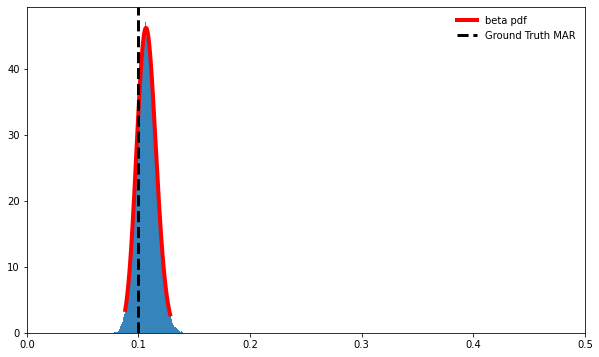

In [1108]:
from scipy.stats import beta
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(10,6))

a=pyro.param('alpha_q').data.numpy()
b=pyro.param('beta_q').data.numpy()

r = beta.rvs(a, b, size=100000)

x = np.linspace(beta.ppf(0.01, a, b),
                beta.ppf(0.99, a, b), 10000)

ax.plot(x, beta.pdf(x, a, b),
       'r-', lw=4, label='beta pdf')

ax.hist(r, density=True, bins='auto', histtype='stepfilled', alpha=0.9)

ax.axvline(x = .1, color = 'black', label = 'Ground Truth MAR',lw=3, linestyle="dashed")
ax.set_xlim([0, .5])
ax.legend(loc='best', frameon=False)
plt.show()

In [1109]:
missing_data

,Intensity,obs_Intensity,Run,Protein,Feature,True_mean,True_std,MAR,MNAR,Missing
0,25.321131,25.321131,0.0,0.0,0.0,25.137302,0.793676,False,False,0
1,24.287235,24.287235,1.0,0.0,0.0,24.137302,0.793676,False,False,0
2,NaN,26.352320,2.0,0.0,0.0,26.137302,0.793676,True,False,1
3,25.249428,25.249428,0.0,0.0,1.0,25.137302,0.793676,False,False,0
4,NaN,24.301430,1.0,0.0,1.0,24.137302,0.793676,True,False,1
...,...,...,...,...,...,...,...,...,...,...
1495,25.351490,25.351490,1.0,49.0,8.0,24.801958,0.776132,False,False,0
1496,27.356909,27.356909,2.0,49.0,8.0,26.801958,0.776132,False,False,0
1497,NaN,26.391893,0.0,49.0,9.0,25.801958,0.776132,True,False,1
1498,25.417458,25.417458,1.0,49.0,9.0,24.801958,0.776132,False,False,0


In [1114]:
tracker = list()
num_tracker=0
for i in range(50):
    c=16.
    mu = pyro.param('mu_loc_{}'.format(i)).data
    sigma = 2**pyro.param('sigma_loc_{}'.format(i)).data
    br = pyro.param('br_loc_{}'.format(i)).data
    bf = pyro.param('bf_loc_{}'.format(i)).data
    
    mean = mu + torch.sum(br*data[i, :,2:4], dim=1) + torch.sum(bf*data[i, :,4:], dim=1)
    cdf_prob = (c - mean)/sigma
    mnar_prob = torch.tensor(norm.cdf(cdf_prob.detach().numpy()))
    mar = torch.tensor(a/(a+b))
    # print(mar)
    # print(mnar_prob)
    # print(mean)
    # print(mnar_prob > mar)
    
#     if cdf_prob > mar:
#         impute_reason = "MNAR"
#     else:
#         impute_reason = "MAR"
    # print(len(mnar_prob > mar))
    tracker.append(mnar_prob > mar)
    missing_data.loc[num_tracker:(num_tracker+29),"MNAR_Imp"] = (mnar_prob > mar).detach().numpy()
    # print(mean)
    missing_data.loc[num_tracker:(num_tracker+29),"mean_Imp"] = mean.detach().numpy()
    missing_data.loc[num_tracker:(num_tracker+29),"std_Imp"] = sigma.detach().numpy()
    missing_data.loc[num_tracker:(num_tracker+29),"mnar_prob"] = mnar_prob.detach().numpy()
    missing_data.loc[num_tracker:(num_tracker+29),"mar_prob"] = mar.detach().numpy()
    num_tracker+=30
#     tracker+=10
    

In [1115]:
sum(missing_data[missing_data["Missing"] == 1]["MNAR"] == missing_data[missing_data["Missing"] == 1]["MNAR_Imp"])

201

In [1116]:
sum(missing_data[missing_data["Missing"] == 1]["MNAR"] != missing_data[missing_data["Missing"] == 1]["MNAR_Imp"])

15

In [1117]:
missing_data[(missing_data["Missing"] == 1) & (missing_data["MNAR"] != missing_data["MNAR_Imp"])] 

,Intensity,obs_Intensity,Run,Protein,Feature,True_mean,True_std,MAR,MNAR,Missing,MNAR_Imp,mean_Imp,std_Imp,mnar_prob,mar_prob
241,NaN,15.983174,1.0,8.0,0.0,18.374580,1.416110,False,True,1,False,17.962798,0.911415,1.563687e-02,0.107401
415,NaN,16.081148,1.0,13.0,8.0,15.894388,0.757788,True,False,1,True,16.148257,0.180740,2.060290e-01,0.107401
418,NaN,16.246807,1.0,13.0,9.0,15.894388,0.757788,True,False,1,True,16.192566,0.180740,1.433410e-01,0.107401
464,NaN,17.050137,2.0,15.0,4.0,16.946491,0.683570,True,False,1,True,16.552610,0.681624,2.087618e-01,0.107401
571,NaN,16.147758,1.0,19.0,0.0,16.188950,0.736874,True,False,1,True,16.086214,0.220625,3.479834e-01,0.107401
595,NaN,16.017323,1.0,19.0,8.0,16.188950,0.736874,True,False,1,True,15.946646,0.220625,5.955442e-01,0.107401
666,NaN,14.747516,0.0,22.0,2.0,16.094223,0.839799,True,True,1,False,16.348989,0.206246,4.531381e-02,0.107401
668,NaN,15.742606,2.0,22.0,2.0,17.094223,0.839799,False,True,1,False,17.338817,0.206246,4.253657e-11,0.107401
679,NaN,16.081652,1.0,22.0,6.0,15.094223,0.839799,True,False,1,True,16.116479,0.206246,2.861197e-01,0.107401
1015,NaN,16.005463,1.0,33.0,8.0,16.731352,1.023272,True,False,1,True,16.024465,0.140036,4.306543e-01,0.107401


<AxesSubplot:>

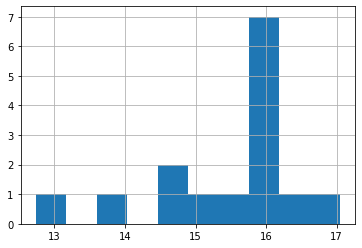

In [14]:
pd.Series(np.array([15.983174,
16.081148,
16.246807,
17.050137,
16.147758,
16.017323,
14.747516,
15.742606,
16.081652,
16.005463,
13.701717,
12.735981,
14.720817,
15.984986,
14.994398])).hist()

## Bayesian Regression with missing value imputation, soft censor

In [301]:
## Simulate some data
def simulate_data(num_proteins, num_runs, num_features, mar_thresh=.05, gen_missing=True):

    sim_data=pd.DataFrame()
    missing = list()
    mu = list()
    sigma = list()

    ## Generate data
    row=0
    for i in range(num_proteins):
        mu = dist.Uniform(15., 30.).sample()
        mu2 = mu-1
        mu3 = mu+1
        sigma = dist.Uniform(.5, 1.5).sample()
        
        for j in range(num_features):
            val = dist.Normal(mu, sigma).sample()
            sim_data.loc[row,"Intensity"] = float(val)
            sim_data.loc[row,"True_Intensity"] = float(val)
            sim_data.loc[row,"Run"] = 0
            sim_data.loc[row,"Protein"] = i
            sim_data.loc[row,"Feature"] = j
            sim_data.loc[row,"True_mean"] = float(mu)
            sim_data.loc[row,"True_std"] = float(sigma)
            
            val2 = dist.Normal(val-1., .05).sample()
            sim_data.loc[row+1,"Intensity"] = float(val2)
            sim_data.loc[row+1,"True_Intensity"] = float(val2)
            sim_data.loc[row+1,"Run"] = 1
            sim_data.loc[row+1,"Protein"] = i
            sim_data.loc[row+1,"Feature"] = j
            sim_data.loc[row+1,"True_mean"] = float(mu2)
            sim_data.loc[row+1,"True_std"] = float(sigma)
            
            val3 = dist.Normal(val+1., .05).sample()
            sim_data.loc[row+2,"Intensity"] = float(val3)
            sim_data.loc[row+2,"True_Intensity"] = float(val3)
            sim_data.loc[row+2,"Run"] = 2
            sim_data.loc[row+2,"Protein"] = i
            sim_data.loc[row+2,"Feature"] = j
            sim_data.loc[row+2,"True_mean"] = float(mu3)
            sim_data.loc[row+2,"True_std"] = float(sigma)
            
            row+=3
    
    if gen_missing:
        for i in range(len(sim_data)):
            mar_prob = np.random.uniform(0,1)
            mnar_prob = np.random.uniform(0,1)
            
            mnar_thresh = 1 / (1 + np.exp(- 10 + (.5*sim_data.loc[i, "True_Intensity"])))
            sim_data.loc[i, "MNAR_threshold"] = mnar_thresh
            
            if mar_prob < mar_thresh:
                sim_data.loc[i, "Intensity"] = np.nan
                sim_data.loc[i, "MAR"] = True
            else:
                sim_data.loc[i, "MAR"] = False

            if mnar_prob < mnar_thresh:
                sim_data.loc[i, "Intensity"] = np.nan
                sim_data.loc[i, "MNAR"] = True
            else:
                sim_data.loc[i, "MNAR"] = False


    sim_data.loc[:, "Missing"] = np.isnan(sim_data["Intensity"])*1
    
    return sim_data

In [583]:
missing_data = simulate_data(10, 3, 10, mar_thresh=.1, gen_missing=True)
missing_data

,Intensity,True_Intensity,Run,Protein,Feature,True_mean,True_std,MNAR_threshold,MAR,MNAR,Missing
0,NaN,23.466591,0.0,0.0,0.0,24.305634,0.755242,0.150167,False,True,1
1,22.499285,22.499285,1.0,0.0,0.0,23.305634,0.755242,0.222762,False,False,0
2,24.446850,24.446850,2.0,0.0,0.0,25.305634,0.755242,0.097667,False,False,0
3,23.123972,23.123972,0.0,0.0,1.0,24.305634,0.755242,0.173362,False,False,0
4,NaN,22.145102,1.0,0.0,1.0,23.305634,0.755242,0.254918,True,False,1
...,...,...,...,...,...,...,...,...,...,...,...
295,24.521049,24.521049,1.0,9.0,8.0,24.585861,1.319987,0.094445,False,False,0
296,26.541367,26.541367,2.0,9.0,8.0,26.585861,1.319987,0.036591,False,False,0
297,NaN,25.276798,0.0,9.0,9.0,25.585861,1.319987,0.066708,True,False,1
298,24.255280,24.255280,1.0,9.0,9.0,24.585861,1.319987,0.106439,False,False,0


In [572]:
def regression_model(data=None, num_proteins=10, num_features = 9, num_runs = 2):
    
    ## MAR indicator
    alpha_q = pyro.sample("alpha_q", dist.Normal(10., .01))
    beta_q = pyro.sample("beta_q", dist.Normal(100., .1))
    
    # mar_prob = pyro.sample("MAR", dist.Beta(alpha, beta))
    mar = pyro.sample("MAR", dist.Beta(alpha_q, beta_q))
    
    beta0_mu = pyro.sample("beta0_mu", dist.Normal(torch.tensor(10.), torch.tensor(.01)))
    beta1_mu = pyro.sample("beta1_mu", dist.Normal(torch.tensor(.5), torch.tensor(.001)))
    
    beta0 = pyro.sample("beta0", dist.Normal(beta0_mu, torch.tensor(.01)))
    beta1 = pyro.sample("beta1", dist.Normal(beta1_mu, torch.tensor(.0001)))
    
    for protein in pyro.plate("protein", num_proteins):
    
        mu = pyro.sample("mu_{0}".format(protein), dist.Uniform(5.,40.))
        sigma = pyro.sample("sigma_{0}".format(protein), 
                            dist.Uniform(0.,100.))
        
        with pyro.plate("runs_{}".format(protein), num_runs):
            br = pyro.sample("bR_{0}".format(protein), 
                             dist.Normal(torch.zeros(num_runs), torch.ones(num_runs)))
        with pyro.plate("features_{}".format(protein), num_features):    
            bf = pyro.sample("bF_{0}".format(protein), 
                         dist.Normal(torch.zeros(num_features), torch.ones(num_features)))
        
        mean = mu + torch.sum(br*data[protein, :,2:4], dim=1) + torch.sum(bf*data[protein, :,4:], dim=1)
        
        with pyro.plate("data_{0}".format(protein), len(data[protein, :, 0])):
            
            # true_obs = pyro.sample("true_obs_{0}".format(protein), dist.Normal(mean, sigma))
            
            # mnar = pyro.sample("mnar_prob_{0}".format(protein), dist.Delta()
#             mnar = 1/(1 + torch.exp(-beta0 + (beta1*mean)))
            
#             missing_prob = mar * ((1-mar)*mnar)
            # print(mnar, mar)
            # odds = -beta0 + (beta1*mean)
            # mnar = odds / (1 + odds)
            
            mnar = 1/(1+torch.exp(-beta0 + (beta1*mean)))
            # print(mnar)
            missing_prob = mar * ((1-mar)*mnar)
            
            missing = pyro.sample("missing_{0}".format(protein), 
                        dist.Bernoulli(probs=missing_prob), 
                                  obs=data[protein, :, 1])
            
            with poutine.mask(mask=(missing == 0)):
                pyro.sample("obs_{0}".format(protein), 
                            dist.Normal(mean, sigma), obs=data[protein, :, 0])
                # pyro.sample("obs_{0}".format(protein), 
                #                 dist.Delta(true_obs), obs=data[protein, :, 0])
            

def regression_guide(data=None, num_proteins=10, num_features = 9, num_runs = 2, c=16.):
    
    ## MAR
    alpha_q_mu = pyro.param("alpha_q_mu", torch.tensor(10.0),
                         constraint=constraints.positive)
    alpha_q_std = pyro.param("alpha_q_std", torch.tensor(1.),
                         constraint=constraints.positive)
    alpha_q = pyro.sample("alpha_q", dist.Normal(alpha_q_mu, alpha_q_std))
    
    beta_q_mu = pyro.param("beta_q_mu", torch.tensor(100.0),
                         constraint=constraints.positive)
    beta_q_std = pyro.param("beta_q_std", torch.tensor(5.),
                         constraint=constraints.positive)
    beta_q = pyro.sample("beta_q", dist.Normal(beta_q_mu, beta_q_std))
    
    mar = pyro.sample("MAR", dist.Beta(alpha_q, beta_q))
    mar_prob = torch.log(mar/(1-mar))
    
    beta0_mu_mu = pyro.param("beta0_mu_mu", torch.tensor(10.0))
    beta0_mu_std = pyro.param("beta0_mu_std", torch.tensor(1.),
                             constraint=constraints.positive)
    beta0_mu = pyro.sample("beta0_mu", dist.Normal(beta0_mu_mu, beta0_mu_std))
    
    beta1_mu_mu = pyro.param("beta1_mu_mu", torch.tensor(.5))
    beta1_mu_std = pyro.param("beta1_mu_std", torch.tensor(.1),
                             constraint=constraints.positive)
    beta1_mu = pyro.sample("beta1_mu", dist.Normal(beta1_mu_mu,beta1_mu_std))
    
    beta0 = pyro.sample("beta0", dist.Normal(beta0_mu, torch.tensor(.01)))
    beta1 = pyro.sample("beta1", dist.Normal(beta1_mu, torch.tensor(.0001)))
    
    for protein in pyro.plate("protein", num_proteins):
        
        ## Sample mean
        mu_loc = pyro.param("mu_loc_{}".format(protein), torch.tensor(20.))
        mu_scale = pyro.param("mu_scale_{}".format(protein), torch.tensor(2.),
                             constraint=constraints.positive)
        mu = pyro.sample("mu_{}".format(protein), dist.Normal(mu_loc, mu_scale))
        
        ## Sample std
        sigma_loc = pyro.param("sigma_loc_{}".format(protein), torch.tensor(0.))#,
                                 # constraint=constraints.positive)
        sigma_scale = pyro.param("sigma_scale_{}".format(protein), torch.tensor(.25),
                                 constraint=constraints.positive)
        sigma = pyro.sample("sigma_{}".format(protein),
                            dist.LogNormal(sigma_loc, sigma_scale))
        
        ## Coefficients
        br_loc = pyro.param("br_loc_{0}".format(protein), torch.randn(num_runs))
        br_scale = pyro.param("br_scale_{0}".format(protein), torch.ones(num_runs),
                                   constraint=constraints.positive)
        
        bf_loc = pyro.param("bf_loc_{0}".format(protein), torch.randn(num_features))
        bf_scale = pyro.param("bf_scale_{0}".format(protein), torch.ones(num_features),
                                   constraint=constraints.positive)

        with pyro.plate("runs_{}".format(protein), num_runs):
            br = pyro.sample("bR_{0}".format(protein), 
                             dist.Normal(br_loc, br_scale))
        with pyro.plate("features_{}".format(protein), num_features):
            bf = pyro.sample("bF_{0}".format(protein), 
                             dist.Normal(bf_loc, bf_scale))
        
        ## Mean calculation
        mean = mu + torch.sum(br*data[protein, :,2:4], dim=1) + torch.sum(bf*data[protein, :,4:], dim=1)
        
        # with pyro.plate("data_{0}".format(protein), len(data[protein, :, 0])):
        #     pyro.sample("true_obs_{0}".format(protein), dist.Normal(mean, sigma))
#             pyro.sample("true_obs_{0}".format(protein), dist.Normal(mean, sigma))
            # pyro.sample("mnar_prob_{0}".format(protein), dist.Delta(1/(1 + torch.exp(-beta0 + (beta1*true_obs)))))


In [587]:
data = missing_data.loc[:, ["Run", "Feature", "Intensity", "Missing"]]
data.loc[:, "Run"] = data.loc[:, "Run"].astype(str)
data.loc[:, "Feature"] = data.loc[:, "Feature"].astype(str)
data = pd.get_dummies(data, drop_first=True)
data = data.values.reshape(10, 30, 13)

data = torch.tensor(data)
data = torch.nan_to_num(data, 0.)

In [589]:
data.shape

torch.Size([10, 30, 13])

In [574]:
# svi = SVI(regression_model,
#           regression_guide,
#           Adam({"lr": .005}),
#           loss=Trace_ELBO())

num_iters = 3000
initial_lr = 0.01
gamma = 0.01  # final learning rate will be gamma * initial_lr
lrd = gamma ** (1 / num_iters)
optim = pyro.optim.ClippedAdam({'lr': initial_lr, 'lrd': lrd})

svi = SVI(regression_model,
          regression_guide,
          optim,
          loss=Trace_ELBO())

pyro.clear_param_store()
for i in range(num_iters):
    elbo = svi.step(data, num_proteins=10, num_features = 9, num_runs = 2)
    if i % 100 == 0:
        print(str(i) + ": "+ str(elbo))

0: 29975.307854949093
100: 4193.140773866308
200: 1557.2273782722336
300: 1192.9150512571214
400: 1039.9700939927359
500: 1095.5219855503778
600: 952.4932967691218
700: 902.1298035614172
800: 986.4060395796664
900: 935.6081876819735
1000: 922.1001050469711
1100: 909.378119646823
1200: 806.7759542151281
1300: 955.9507261538777
1400: 897.5893197247358
1500: 898.7334067192976
1600: 872.76404823977
1700: 875.2839699299396
1800: 871.640327967806
1900: 840.182429736198
2000: 818.7305183385768
2100: 874.5930049993584
2200: 863.3597298451577
2300: 857.4246979399986
2400: 857.9773896412482
2500: 901.9049484973295
2600: 862.0570551367651
2700: 844.469239197558
2800: 835.2529091368378
2900: 829.7516141547014


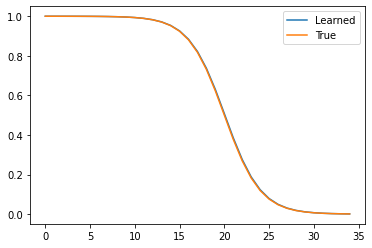

In [576]:
def log_reg(x, learned):
    if learned:
        return 1/(1 + np.exp(-pyro.get_param_store()["beta0_mu_mu"].detach().numpy() +
                             (pyro.get_param_store()["beta1_mu_mu"].detach().numpy()*x)))
    else:
        return 1/(1 + np.exp(-10 + (.5*x)))

fig, ax = plt.subplots()
ax.plot(np.arange(0,35), [log_reg(i, True) for i in np.arange(0,35)], label="Learned")
ax.plot(np.arange(0,35), [log_reg(i, False) for i in np.arange(0,35)], label="True")
plt.legend()

In [577]:
pyro.get_param_store()["beta0_mu_mu"]

tensor(10.0038, requires_grad=True)

In [578]:
pyro.get_param_store()["beta1_mu_mu"]

tensor(0.4986, requires_grad=True)

In [579]:
pyro.get_param_store()["alpha_q_mu"]

tensor(10.0065, grad_fn=<AddBackward0>)

In [580]:
pyro.get_param_store()["beta_q_mu"]

tensor(100.0202, grad_fn=<AddBackward0>)

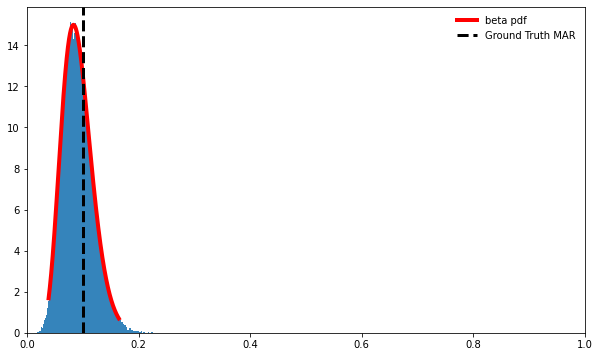

In [581]:
from scipy.stats import beta
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(10,6))

a=pyro.get_param_store()["alpha_q_mu"].detach().numpy()
b=pyro.get_param_store()["beta_q_mu"].detach().numpy()

r = beta.rvs(a, b, size=100000)

x = np.linspace(beta.ppf(0.01, a, b),
                beta.ppf(0.99, a, b), 10000)

ax.plot(x, beta.pdf(x, a, b),
       'r-', lw=4, label='beta pdf')

ax.hist(r, density=True, bins='auto', histtype='stepfilled', alpha=0.9)

ax.axvline(x = .1, color = 'black', label = 'Ground Truth MAR',lw=3, linestyle="dashed")
ax.set_xlim([0, 1.])
ax.legend(loc='best', frameon=False)
plt.show()

In [582]:
for i in range(10):
    temp_mean = pyro.get_param_store()['mu_loc_{0}'.format(i)]
    run_effect = pyro.get_param_store()['br_loc_{0}'.format(i)]
    run_mean = temp_mean + run_effect
    run_mean = torch.cat((temp_mean.reshape(1), run_mean))
    
    true_mean = pd.unique(missing_data[missing_data["Protein"] == i]['True_mean'])
    difference = torch.tensor(true_mean) - run_mean
    print("Protein {0}".format(i), difference.detach().numpy())
    

Protein 0 [ 0.83226776 -0.13172531  0.01894188]
Protein 1 [2.18174362 0.87334633 1.61630249]
Protein 2 [1.16558456 0.28273773 0.47352028]
Protein 3 [-0.83029556 -1.18791199  0.90139484]
Protein 4 [4.61654854 3.10985565 4.21713638]
Protein 5 [-0.10476685  0.17221069  0.25642586]
Protein 6 [ 0.48881531 -0.01571465  0.29278564]
Protein 7 [1.05431366 0.75315285 0.88598633]
Protein 8 [1.25398445 0.09912109 0.52735519]
Protein 9 [1.27292633 0.83453941 1.20271301]


In [559]:
print(pyro.get_param_store()['mu_loc_9'])
print(pyro.get_param_store()['br_loc_9'])

tensor(21.0336, requires_grad=True)
tensor([-0.9430,  1.0037], requires_grad=True)


In [560]:
print(pyro.get_param_store()['mu_scale_9'])
print(pyro.get_param_store()['br_scale_9'])

tensor(0.0784, grad_fn=<AddBackward0>)
tensor([0.1430, 0.1234], grad_fn=<AddBackward0>)


In [561]:
pd.unique(missing_data[missing_data["Protein"] == 9]['True_mean'])

array([21.7077713, 20.7077713, 22.7077713])

In [558]:
missing_data[missing_data["Protein"] == 9].groupby("Run")["Missing"].sum()

Run
0.0    6
1.0    6
2.0    5
Name: Missing, dtype: int64

## Vectorize Model

In [139]:
def regression_model(data=None, num_proteins=10, num_features = 9, num_runs = 2):
    
    with pyro.plate("protein", num_proteins):
    
        mu = pyro.sample("mu", dist.Uniform(torch.full((num_proteins,), 10.),
                                            torch.full((num_proteins,), 35.)))
        sigma = pyro.sample("sigma", 
                            dist.Uniform(torch.full((num_proteins,), 0.),
                                         torch.full((num_proteins,), 20.)))
        
        with pyro.plate("runs", num_runs):
            br = pyro.sample("bR", 
                             dist.Normal(torch.zeros((num_runs, num_proteins)), 
                                         torch.ones((num_runs, num_proteins))))
        with pyro.plate("features", num_features):    
            bf = pyro.sample("bF", 
                         dist.Normal(torch.zeros((num_features, num_proteins)), 
                                     torch.ones((num_features, num_proteins))))
        product = list()
        for i in range(num_proteins):
            mean = mu + torch.sum(br[:, i]*data[i, :,1:3], dim=1) + torch.sum(bf[:, i]*data[i, :,3:], dim=1)
            product.append(mean)
            
        return(product)
        
#         with pyro.plate("data_{0}".format(protein), len(data[protein, :, 0])):
#             pyro.sample("obs_{0}".format(protein), 
#                         dist.Normal(mean, sigma), obs=data[protein, :, 0])

def regression_guide(data=None, num_proteins=10, num_features = 9, num_runs = 2):
    
    for protein in pyro.plate("protein", num_proteins):
        
        ## Sample mean
        mu_loc = pyro.param("mu_loc_{}".format(protein), torch.tensor(20.))
        mu_scale = pyro.param("mu_scale_{}".format(protein), torch.tensor(2.),
                             constraint=constraints.positive)
        mu = pyro.sample("mu_{}".format(protein), dist.Normal(mu_loc, mu_scale))
        
        ## Sample std
        sigma_loc = pyro.param("sigma_loc_{}".format(protein), torch.tensor(0.))#,
                                 # constraint=constraints.positive)
        sigma_scale = pyro.param("sigma_scale_{}".format(protein), torch.tensor(.25),
                                 constraint=constraints.positive)
        sigma = pyro.sample("sigma_{}".format(protein),
                            dist.LogNormal(sigma_loc, sigma_scale))
        
        ## Coefficients
        br_loc = pyro.param("br_loc_{0}".format(protein), torch.randn(num_runs))
        br_scale = pyro.param("br_scale_{0}".format(protein), torch.ones(num_runs),
                                   constraint=constraints.positive)
        
        bf_loc = pyro.param("bf_loc_{0}".format(protein), torch.randn(num_features))
        bf_scale = pyro.param("bf_scale_{0}".format(protein), torch.ones(num_features),
                                   constraint=constraints.positive)

        with pyro.plate("runs_{}".format(protein), num_runs):
            br = pyro.sample("bR_{0}".format(protein), 
                             dist.Normal(br_loc, br_scale))
        with pyro.plate("features_{}".format(protein), num_features):    
            bf = pyro.sample("bF_{0}".format(protein), 
                             dist.Normal(bf_loc, bf_scale))
        
        ## Mean calculation
        mean = mu + torch.sum(br*data[protein, :,1:3], dim=1) + torch.sum(bf*data[protein, :,3:], dim=1)


## Regression imputation

In [ ]:
def regression_model(data=None, num_proteins=50, num_features = 9, num_runs = 2):
    
    for protein in pyro.plate("protein", num_proteins):
    
        mu = pyro.sample("mu_{0}".format(protein), dist.Uniform(10.,35.))
        sigma = pyro.sample("sigma_{0}".format(protein), 
                    dist.Uniform(0.,20.))
        
        with pyro.plate("runs_{}".format(protein), num_runs):
            br = pyro.sample("bR_{0}".format(protein), 
                             dist.Normal(torch.zeros(num_runs), torch.ones(num_runs)))
        with pyro.plate("features_{}".format(protein), num_features):    
            bf = pyro.sample("bF_{0}".format(protein), 
                         dist.Normal(torch.zeros(num_features), torch.ones(num_features)))
        
        mean = mu + torch.sum(br*data[protein, :,1:3], dim=1) + torch.sum(bf*data[protein, :,3:], dim=1)
        
        with pyro.plate("data_{0}".format(protein), len(data[protein, :, 0])):
            pyro.sample("obs_{0}".format(protein), 
                        dist.Normal(mean, sigma), obs=data[protein, :, 0])

def regression_guide(data=None, num_proteins=50, num_features = 9, num_runs = 2):
    
    for protein in pyro.plate("protein", num_proteins):
        
        ## Sample mean
        mu_loc = pyro.param("mu_loc_{}".format(protein), torch.tensor(20.))
        mu_scale = pyro.param("mu_scale_{}".format(protein), torch.tensor(2.),
                             constraint=constraints.positive)
        mu = pyro.sample("mu_{}".format(protein), dist.Normal(mu_loc, mu_scale))
        
        ## Sample std
        sigma_loc = pyro.param("sigma_loc_{}".format(protein), torch.tensor(0.))#,
                                 # constraint=constraints.positive)
        sigma_scale = pyro.param("sigma_scale_{}".format(protein), torch.tensor(.25),
                                 constraint=constraints.positive)
        sigma = pyro.sample("sigma_{}".format(protein),
                            dist.LogNormal(sigma_loc, sigma_scale))
        
        ## Coefficients
        br_loc = pyro.param("br_loc_{0}".format(protein), torch.randn(num_runs))
        br_scale = pyro.param("br_scale_{0}".format(protein), torch.ones(num_runs),
                                   constraint=constraints.positive)
        
        bf_loc = pyro.param("bf_loc_{0}".format(protein), torch.randn(num_features))
        bf_scale = pyro.param("bf_scale_{0}".format(protein), torch.ones(num_features),
                                   constraint=constraints.positive)

        with pyro.plate("runs_{}".format(protein), num_runs):
            br = pyro.sample("bR_{0}".format(protein), 
                             dist.Normal(br_loc, br_scale))
        with pyro.plate("features_{}".format(protein), num_features):    
            bf = pyro.sample("bF_{0}".format(protein), 
                             dist.Normal(bf_loc, bf_scale))
        
        ## Mean calculation
        mean = mu + torch.sum(br*data[protein, :,1:3], dim=1) + torch.sum(bf*data[protein, :,3:], dim=1)


## First model (deprecated)

In [927]:
def model(c=16., num_proteins=100, data_intensity=None, data_missing=None):
    
    # assert data_missing.dtype == torch.uint8
    
    ## MAR indicator
    alpha=torch.tensor(5.0)
    beta=torch.tensor(10.0)
    mar = pyro.sample("MAR", dist.Beta(alpha, beta))
    
    ## TODO: Vectorize model using "with plate"
    # loop over the observed data
    for batch in pyro.plate("protein_plate", size=num_proteins):
    # with pyro.plate("protein_plate", num_proteins, 1, dim=-2) as batch:
    
        mu = pyro.sample("mu_{}".format(batch), dist.Normal(20., 2.))
        sigma = pyro.sample("sigma_{}".format(batch), dist.Normal(1., .1))#.to_event(1))
            
        ## Maybe need this to mask missing values? it legit doesnt work
        # with poutine.mask(mask=data_missing[batch,:]):
        
        ## MNAR indicator
        ## Calculations
        cdf_prob = (c - mu)/sigma
        mnar_prob = torch.tensor(norm.cdf(cdf_prob.detach().numpy()))
        mnar = pyro.sample("MNAR_{}".format(batch), dist.Bernoulli(probs = mnar_prob))
        
        ## TODO: Vectorize
        for j in pyro.plate("peptide_plate_{}".format(batch), size=10):
            
            missing_prob = max(mar, mnar)
            # missing_prob = torch.tensor([max(mar, mnar[i]) for i in range(len(mnar))]) ## TODO: For vectorization (?)
            
            pyro.sample("intensity_{0}_{1}".format(batch,j), dist.Normal(mu, sigma), 
                        obs=data_intensity[batch,j].flatten())
            obs = pyro.sample("obs_{0}_{1}".format(batch,j), dist.Bernoulli(probs=missing_prob), 
                              obs=data_missing.float()[batch,j].flatten())


Model with median polish correction

In [166]:
def model(c=16., num_proteins=100, num_features = 10, num_runs = 3, data_intensity=None, data_missing=None):
    
    # assert data_missing.dtype == torch.uint8
    
    ## MAR indicator
    alpha=torch.tensor(5.0)
    beta=torch.tensor(10.0)
    mar = pyro.sample("MAR", dist.Beta(alpha, beta))
    
    ## TODO: Vectorize model using "with plate"
    # loop over the observed data
    for protein in pyro.plate("protein_plate", size=num_proteins):
    # with pyro.plate("protein_plate", num_proteins, 1, dim=-2) as batch:
    
        mu = pyro.sample("mu_{}".format(protein), dist.Normal(20., 2.))
        sigma = pyro.sample("sigma_{}".format(protein), dist.Normal(1., .1))#.to_event(1))
            
        ## Maybe need this to mask missing values? it legit doesnt work
        # with poutine.mask(mask=data_missing[batch,:]):
        if data_intensity is not None:
            med_polish = median_polish(data_intensity[protein,:,:], eps = 0.01, 
                                       maxiter=10, trace_iter=False, na_rm=True)
            
        ## TODO: Vectorize
        for run in pyro.plate("run_plate_{}".format(protein), size=num_runs):
            
            ## MNAR indicator
            ## Calculations
            if data_intensity is not None:
                cdf_prob = (c - mu - med_polish['col'][run])/sigma
            else:
                cdf_prob = (c - mu)/sigma
                
            mnar_prob = torch.tensor(norm.cdf(cdf_prob.detach().numpy()))
            mnar = pyro.sample("MNAR_{0}_{1}".format(protein, run), 
                               dist.Bernoulli(probs = mnar_prob))
            
            for feature in pyro.plate("peptide_plate_{0}_{1}".format(protein, run), size=num_features):
        
                missing_prob = max(mar, mnar)
                # missing_prob = torch.tensor([max(mar, mnar[i]) for i in range(len(mnar))]) ## TODO: For vectorization (?)

                pyro.sample("intensity_{0}_{1}_{2}".format(protein, feature, run), 
                            dist.Normal(mu, sigma), 
                            obs=data_intensity[protein, feature, run].flatten())
                obs = pyro.sample("obs_{0}_{1}_{2}".format(protein, feature, run), 
                                  dist.Bernoulli(probs=missing_prob), 
                                  obs=data_missing.float()[protein, feature, run].flatten())


In [167]:
def guide(c=16., num_proteins=100, num_features = 10, num_runs = 3, data_intensity=None, data_missing=None):#
    
    ## MAR
    alpha_q = pyro.param("alpha_q", torch.tensor(5.0),
                         constraint=constraints.positive)
    beta_q = pyro.param("beta_q", torch.tensor(10.0),
                        constraint=constraints.positive)
    pyro.sample("MAR", dist.Beta(alpha_q, beta_q))
    
    for protein in range(num_proteins):
        ## MNAR indicator
        mu_mu = pyro.param("mu_mu_{}".format(protein), torch.tensor(20.0),
                     constraint=constraints.greater_than_eq(10.0))
        mu_std = pyro.param("mu_std_{}".format(protein), torch.tensor(10.0),
                     constraint=constraints.positive)

        std_mu = pyro.param("std_mu_{}".format(protein), torch.tensor(1.),
                     constraint=constraints.positive)
        std_std = pyro.param("std_std_{}".format(protein), torch.tensor(.1),
                     constraint=constraints.positive)

        mu = pyro.sample("mu_{}".format(protein), dist.Normal(mu_mu, mu_std))
        sigma = pyro.sample("sigma_{}".format(protein), dist.Normal(std_mu, std_std))

        cdf_prob = (c - mu)/sigma
        mnar_prob = torch.tensor(norm.cdf(cdf_prob.detach().numpy()))
        
        for run in range(num_runs):
            pyro.sample("MNAR_{0}_{1}".format(protein, run), dist.Bernoulli(probs = mnar_prob))
        

In [168]:
# guide = AutoNormal(poutine.block(model, hide=['MNAR_{}'.format(i) for i in range(100)]))#
# guide = config_enumerate(guide, "sequential")
adam_params = {"lr": 0.1, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
pyro.clear_param_store()

# do gradient steps
n_steps=100
for step in range(n_steps):
    loss = svi.step(min(sim_data.loc[:, "Intensity"]), 
                    1000, 10, 3,
                    torch.nan_to_num(torch.tensor(sim_data.loc[:, "Intensity"]).reshape(1000,10,3),0), 
                    torch.tensor(sim_data.loc[:, "Missing"]).reshape(1000,10,3))

    if step % 10:
        print(loss)

2415651.0326735666
1775763.834474179
1556284.750973947
1301177.0225500937
1089593.3483576416
930808.7336462139
812160.3323180893
725266.9820167483
686542.076765782
607406.6133168966
568767.1197088135
559407.9171248403
559815.7100911149
545621.1845889069
560631.5668456561
571613.6690664798


KeyboardInterrupt: 

In [169]:
results_df = pd.DataFrame()
row=0
for name in pyro.get_param_store().get_all_param_names():
    results_df.loc[row, "Name"] = name
    results_df.loc[row, "Val"] = pyro.param(name).data.numpy()
    row+=1


In [170]:
results_df

,Name,Val
0,alpha_q,2.114869
1,beta_q,26.359510
2,mu_mu_0,24.615030
3,mu_std_0,4.084242
4,std_mu_0,3.084531
...,...,...
3997,std_std_998,0.084580
3998,mu_mu_999,13.980408
3999,mu_std_999,4.370746
4000,std_mu_999,2.443687


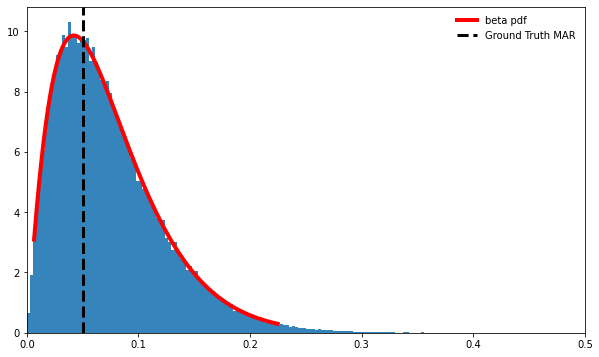

In [171]:
from scipy.stats import beta
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(10,6))

a=results_df.loc[results_df["Name"]=="alpha_q"]["Val"]
b=results_df.loc[results_df["Name"]=="beta_q"]["Val"]

r = beta.rvs(a, b, size=100000)

x = np.linspace(beta.ppf(0.01, a, b),
                beta.ppf(0.99, a, b), 10000)

ax.plot(x, beta.pdf(x, a, b),
       'r-', lw=4, label='beta pdf')

ax.hist(r, density=True, bins='auto', histtype='stepfilled', alpha=0.9)

ax.axvline(x = .05, color = 'black', label = 'Ground Truth MAR',lw=3, linestyle="dashed")
ax.set_xlim([0, .5])
ax.legend(loc='best', frameon=False)
plt.show()

In [172]:
mean_error = sim_data.loc[:, ['Protein', 'True_mean', 'True_std']].drop_duplicates()["True_mean"].values - results_df.loc[results_df["Name"].str.contains("mu_mu")]["Val"].values
std_error = sim_data.loc[:, ['Protein', 'True_mean', 'True_std']].drop_duplicates()["True_std"].values - results_df.loc[results_df["Name"].str.contains("std_mu")]["Val"].values

fig, ax = plt.subplots(1, 2, figsize=(14,6))

ax[0].hist(mean_error, bins=30)
ax[1].hist(std_error, bins=30)

ax[0].set_title("Mean error")
ax[1].set_title("Std error")

fig, ax = plt.subplots(1, 2, figsize=(14,6))

ax[0].hist(sim_data.loc[:, ['Protein', 'True_mean', 'True_std']].drop_duplicates()[mean_error<1.25]["True_mean"].values, bins=30)
ax[1].hist(sim_data.loc[:, ['Protein', 'True_mean', 'True_std']].drop_duplicates()[mean_error>1.25]["True_mean"].values, bins=30)

ax[0].set_xlim(13.,31.)
ax[1].set_xlim(13.,31.)

ax[0].set_title("Low error")
ax[1].set_title("High error")

ValueError: operands could not be broadcast together with shapes (3000,) (1000,) 

In [998]:
sim_data.head()

,Intensity,Protein,Feature,True_mean,True_std,MAR,MNAR,Missing
0,26.303730,0.0,0.0,26.352667,0.518915,False,False,False
1,26.483204,0.0,1.0,26.352667,0.518915,False,False,False
2,25.804752,0.0,2.0,26.352667,0.518915,False,False,False
3,26.708883,0.0,3.0,26.352667,0.518915,False,False,False
4,27.364719,0.0,4.0,26.352667,0.518915,False,False,False


In [1044]:
tracker = 0
for i in range(1000):
    c=16.
    mu = results_df.loc[results_df["Name"] == "mu_mu_{}".format(i)]["Val"].values
    sigma = results_df.loc[results_df["Name"] == "std_mu_{}".format(i)]["Val"].values

    cdf_prob = norm.cdf((c - mu)/sigma)
    mar = .508
    
    if cdf_prob > mar:
        impute_reason = "MNAR"
    else:
        impute_reason = "MAR"
    
    sim_data.loc[tracker:tracker+10, "Impute"] = impute_reason
    tracker+=10
    
    

Text(0.5, 1.0, 'Mean of mislabelled proteins')

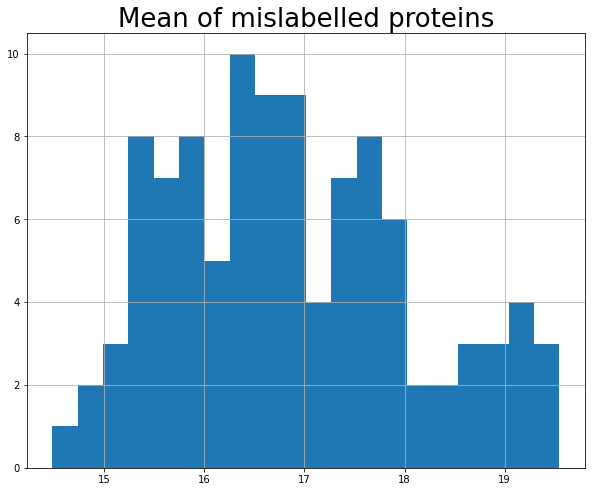

In [1040]:
fig, ax = plt.subplots(figsize=(10,8))
sim_data[((sim_data["Impute"]=="MAR") & (sim_data["MNAR"]==True)) | ((sim_data["Impute"]=="MNAR") & (sim_data["MAR"]==True))]["True_mean"].hist(bins=20, ax=ax)
ax.set_title("Mean of mislabelled proteins", size= 26)

In [1046]:
len(sim_data[(sim_data["Impute"]=="MNAR") & (sim_data["MAR"]==True)])

85

In [1019]:
357/(357+80)

0.816933638443936

In [1023]:
810+80

890

MAR = 357 / 437

MNAR = 810 / 890

In [1031]:
(357+810) / (357+810+80+24)

0.918174665617624

In [1061]:
cdf_prob = norm.cdf((16. - 18 + .5)/1.)
cdf_prob

0.06680720126885807

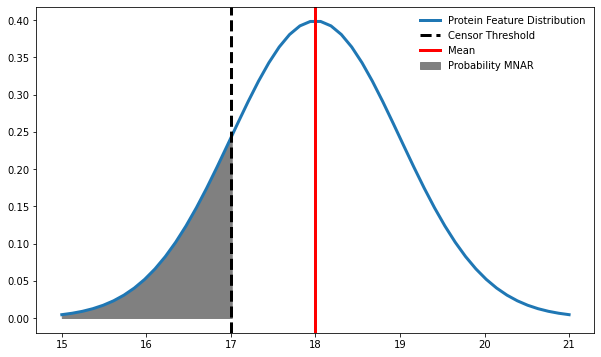

In [977]:
import scipy.stats as stats
import math

fig, ax = plt.subplots(figsize=(10,6))

mu = 18
variance = 1
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma)
ax.plot(x, stats.norm.pdf(x, mu, sigma),lw=3, label="Protein Feature Distribution")
ax.axvline(x = 17., color = 'black', label = 'Censor Threshold',lw=3, linestyle="dashed")
ax.axvline(x = 18., color = 'red', label = 'Mean',lw=3, linestyle="solid")
# ax.axhline(y = .2, xmin=18., xmax=19., color = 'black', lw=3, linestyle="solid")
px=np.arange(15,17.01,.01)
plt.fill_between(px,stats.norm.pdf(px, mu, sigma),color='grey', label="Probability MNAR")
ax.legend(loc='best', frameon=False)

In [ ]:
cdf_prob = norm.cdf((c - mu - run - feature)/sd)
cdf_prob

In [ ]:
def regression_model(data=None, num_proteins=50, num_features = 9, num_runs = 2, c=16.):
    
    ## MAR indicator
    alpha=torch.tensor(1.0)
    beta=torch.tensor(10.0)
    # mar_prob = pyro.sample("MAR", dist.Beta(alpha, beta))
    mar = pyro.sample("MAR", dist.Beta(alpha, beta))
    
    for protein in pyro.plate("protein", num_proteins):
    
        mu = pyro.sample("mu_{0}".format(protein), dist.Uniform(10.,35.))
        sigma = pyro.sample("sigma_{0}".format(protein), 
                    dist.Uniform(0.,10.))
        
        with pyro.plate("runs_{}".format(protein), num_runs):
            br = pyro.sample("bR_{0}".format(protein), 
                             dist.Normal(torch.zeros(num_runs), torch.ones(num_runs)))
        with pyro.plate("features_{}".format(protein), num_features):    
            bf = pyro.sample("bF_{0}".format(protein), 
                         dist.Normal(torch.zeros(num_features), torch.ones(num_features)))
        
        mean = mu + torch.sum(br*data[protein, :,2:4], dim=1) + torch.sum(bf*data[protein, :,4:], dim=1)
        
        cdf_prob = (c - mean)/sigma
        mnar = torch.tensor(norm.cdf(cdf_prob.detach().numpy()))
        
        # mnar_prob = pyro.deterministic("mnar_prob_{0}".format(protein),
        #                     dist.Normal(0,1).cdf(((c - mean)/sigma)))
        
        with pyro.plate("data_{0}".format(protein), len(data[protein, :, 0])):
                
            # mnar = pyro.sample("MNAR_{0}".format(protein), dist.Bernoulli(probs = mnar_prob))
            # mnar = pyro.sample("MNAR_{0}".format(protein), dist.Normal(0, 1))
            # mnar = (mnar < cdf_prob)*1
            # mnar = pyro.deterministic("mnar_prob_{0}".format(protein),
            #                                (mnar < cdf_prob)*1)
            # mar = pyro.sample("MAR_{0}".format(protein), dist.Bernoulli(probs=mar_prob))
            
            # missing_prob = torch.max(mar, mnar)
            missing_prob = 1-((1-mnar) * (1-mar))
            # print(mnar, mar)
            missing = pyro.sample("missing_{0}".format(protein), 
                        dist.Bernoulli(probs=missing_prob), 
                                  obs=data[protein, :, 1])
            
            with poutine.mask(mask=(missing == 0)):
                pyro.sample("obs_{0}".format(protein), 
                                dist.Normal(mean, sigma), obs=data[protein, :, 0])
            
            ## TODO: This is imputation.. not necessary for predicting just MAR vs MNAR
            # with poutine.mask(mask=(missing == 1)):
            #     mnar_mean = mean - sigma
            #     mean_parent = pyro.deterministic("mean_parent_{0}".format(protein),
            #                 torch.where((mnar == 1), mnar_mean, mean),)
            #     std_parent = pyro.deterministic("std_parent_{0}".format(protein),
            #                 torch.where((mnar == 1), sigma/2, sigma),)
            #     pyro.sample("unobs_{0}".format(protein), 
            #                 dist.Normal(mean_parent, std_parent))

def regression_guide(data=None, num_proteins=50, num_features = 9, num_runs = 2, c=16.):
    
    ## MAR
    alpha_q = pyro.param("alpha_q", torch.tensor(5.0),
                         constraint=constraints.positive)
    beta_q = pyro.param("beta_q", torch.tensor(30.0),
                        constraint=constraints.positive)
    mar_prob = pyro.sample("MAR", dist.Beta(alpha_q, beta_q))
    
    for protein in pyro.plate("protein", num_proteins):
        
        ## Sample mean
        mu_loc = pyro.param("mu_loc_{}".format(protein), torch.tensor(20.))
        mu_scale = pyro.param("mu_scale_{}".format(protein), torch.tensor(2.),
                             constraint=constraints.positive)
        mu = pyro.sample("mu_{}".format(protein), dist.Normal(mu_loc, mu_scale))
        
        ## Sample std
        sigma_loc = pyro.param("sigma_loc_{}".format(protein), torch.tensor(0.))#,
                                 # constraint=constraints.positive)
        sigma_scale = pyro.param("sigma_scale_{}".format(protein), torch.tensor(.25),
                                 constraint=constraints.positive)
        sigma = pyro.sample("sigma_{}".format(protein),
                            dist.LogNormal(sigma_loc, sigma_scale))
        
        ## Coefficients
        br_loc = pyro.param("br_loc_{0}".format(protein), torch.randn(num_runs))
        br_scale = pyro.param("br_scale_{0}".format(protein), torch.ones(num_runs),
                                   constraint=constraints.positive)
        
        bf_loc = pyro.param("bf_loc_{0}".format(protein), torch.randn(num_features))
        bf_scale = pyro.param("bf_scale_{0}".format(protein), torch.ones(num_features),
                                   constraint=constraints.positive)

        with pyro.plate("runs_{}".format(protein), num_runs):
            br = pyro.sample("bR_{0}".format(protein), 
                             dist.Normal(br_loc, br_scale))
        with pyro.plate("features_{}".format(protein), num_features):
            bf = pyro.sample("bF_{0}".format(protein), 
                             dist.Normal(bf_loc, bf_scale))
        
        ## Mean calculation
        mean = mu + torch.sum(br*data[protein, :,2:4], dim=1) + torch.sum(bf*data[protein, :,4:], dim=1)
        
        # cdf_prob = (c - mean)/sigma
        # mnar_prob = torch.tensor(norm.cdf(cdf_prob.detach().numpy()))
        # mnar_prob = pyro.param("mnar_prob_{}".format(protein), mnar_prob),
        #                 constraint=constraints.positive)
        
        # mnar_prob = pyro.deterministic("mnar_prob_{0}".format(protein),
        #                     dist.Normal(0,1).cdf(((c - mean)/sigma)))
        
#         with pyro.plate("data_{0}".format(protein), len(data[protein, :, 0])):
            
#             mnar = pyro.sample("MNAR_{0}".format(protein), dist.Bernoulli(probs = mnar_prob))
            # mnar = pyro.sample("MNAR_{0}".format(protein), dist.Normal(0, 1))
            # mnar = (mnar < cdf_prob)*1
            # mnar = pyro.deterministic("mnar_prob_{0}".format(protein),
            #                                (mnar < cdf_prob)*1)
            # mar = pyro.sample("MAR_{0}".format(protein), dist.Bernoulli(probs=mar_prob))
            
            ## TODO: This is imputation.. not necessary for predicting just MAR vs MNAR
#             missing_prob = torch.max(mar, mnar)
            
#             missing = pyro.sample("missing_{0}".format(protein), 
#                         dist.Bernoulli(probs=missing_prob), 
#                                   infer={'is_auxiliary': True})
            
#             with poutine.mask(mask=(missing == 1)):
#                 mnar_mean = mean - sigma
#                 mean_parent = pyro.deterministic("mean_parent_{0}".format(protein),
#                             torch.where((mnar == 1), mnar_mean, mean),)
#                 std_parent = pyro.deterministic("std_parent_{0}".format(protein),
#                             torch.where((mnar == 1), sigma/2, sigma),)
#                 pyro.sample("unobs_{0}".format(protein), 
#                             dist.Normal(mean_parent, std_parent))